# Homework 2

Question 1

        provider_number  year  report_count
0                 10001  1997             1
1                 10001  1998             1
2                 10001  1999             1
3                 10001  2000             1
4                 10001  2001             1
...                 ...   ...           ...
121772           673063  2016             1
121773           673063  2017             1
121774           673064  2016             1
121775           673064  2017             1
121776           673065  2016             1

[121777 rows x 3 columns]


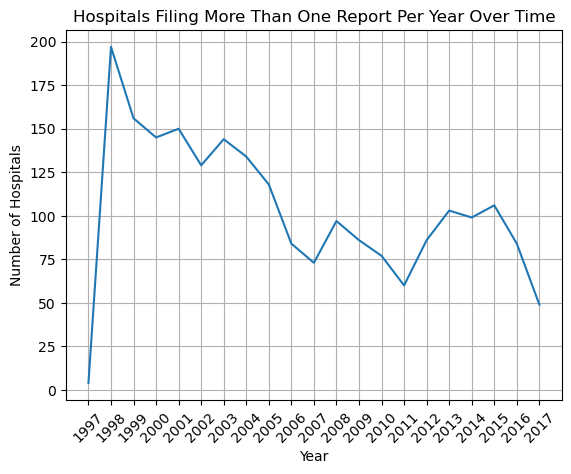

In [51]:
#| echo: false
#1 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

HCRIS = pd.read_csv('/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework2-/data/Output/HCRIS.csv')

# Convert 'fy_start' to datetime FORMAT
HCRIS['fy_start'] = pd.to_datetime(HCRIS['fy_start'], errors='coerce')
HCRIS['year'] = HCRIS['fy_start'].dt.year

# Count hospitals that filed more than one report in the same year
hospital_counts = HCRIS.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

print(hospital_counts)
# Plot the results
plt.figure()
plt.plot(hospitals_over_time.index, hospitals_over_time.values)
plt.xlabel('Year')
plt.xticks(hospitals_over_time.index, rotation=45) 
plt.ylabel('Number of Hospitals')
plt.title('Hospitals Filing More Than One Report Per Year Over Time')
plt.grid(True)
plt.show()



Question 2

In [52]:
#Question 2

#Removing duplicate reports
unique_hospitals = HCRIS.drop_duplicates(subset=['provider_number', 'year'])

#Count of number of unique hospital IDs
unique_hospital_count = unique_hospitals['provider_number'].nunique()

print(f"Number of Unique Hospital IDs: {unique_hospital_count}")



Number of Unique Hospital IDs: 9323


#Question 3

count    1.192340e+05
mean     3.226221e+08
std      6.867871e+08
min      1.000000e+00
25%      2.456732e+07
50%      7.782326e+07
75%      3.215973e+08
max      1.863371e+10
Name: tot_charges, dtype: float64


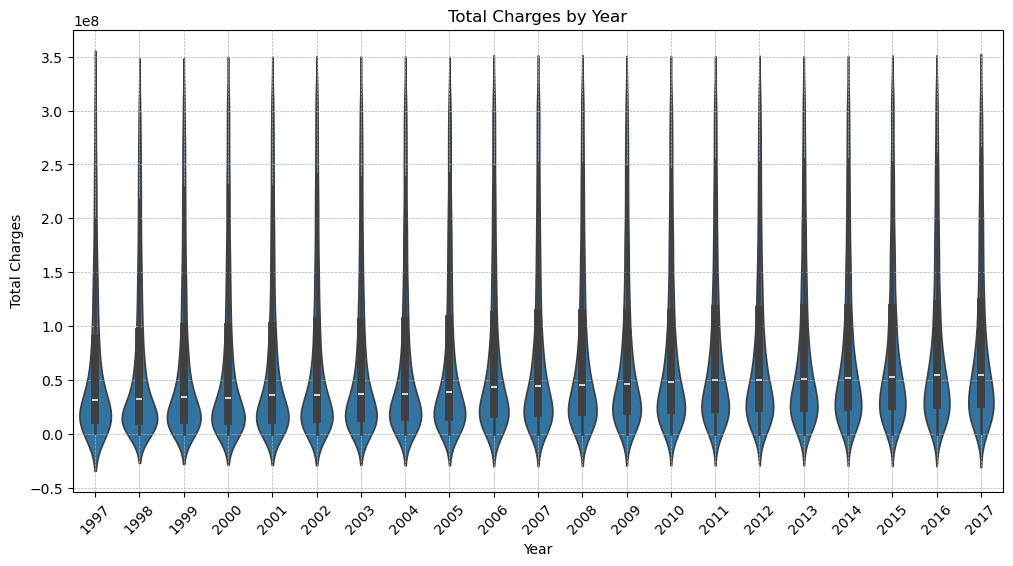

In [58]:
#Question 3 
HCRIS['tot_charges'] = pd.to_numeric(HCRIS['tot_charges'], errors='coerce')

# Convert tot_charges to numeric
HCRIS['tot_charges'] = pd.to_numeric(HCRIS['tot_charges'], errors='coerce')

#Remove rows with missing charges or years, negative values, and outliers
charges_by_year = HCRIS[['year', 'tot_charges']].dropna()
charges_by_year = charges_by_year[charges_by_year['tot_charges'] >= 0]

# Display summary statistics to find  cutoff values
summary_stats = charges_by_year['tot_charges'].describe() 
print(summary_stats)

#creating upper bound limit
upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
charges_by_year = charges_by_year[charges_by_year['tot_charges'] <= upper_bound]

# Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='tot_charges', data=charges_by_year)
plt.title("Total Charges by Year")
plt.xlabel("Year")
plt.ylabel("Total Charges")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Question 4

count    5.882500e+04
mean              inf
std               NaN
min      1.953267e+00
25%      4.789842e+03
50%      7.109387e+03
75%      1.022331e+04
max               inf
Name: estimated_price, dtype: float64


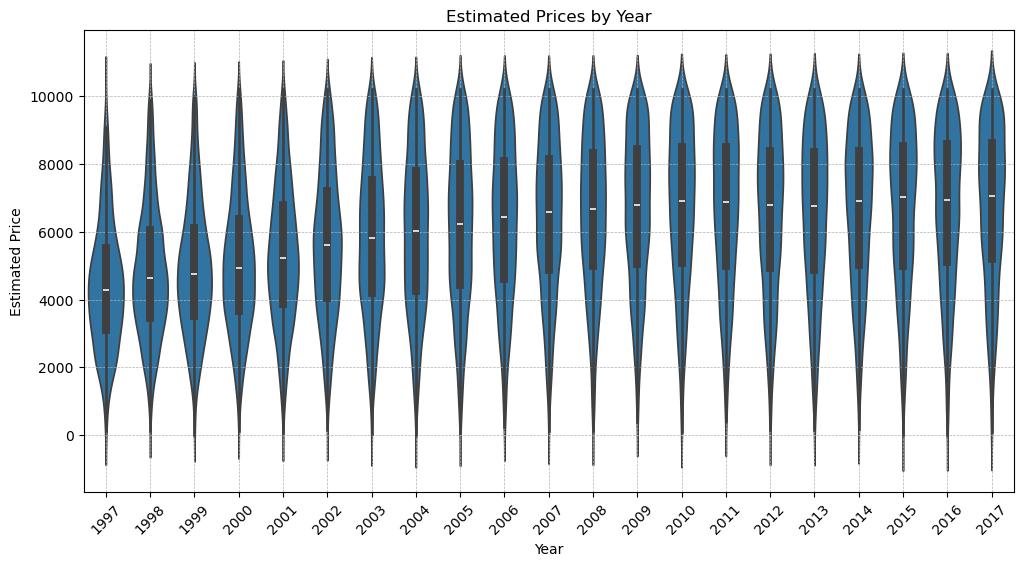

In [54]:
#Question 4

#Converting columns to numeric 
numeric_columns = [
    'tot_discounts', 'tot_charges', 'ip_charges', 'icu_charges', 'ancillary_charges',
    'tot_mcare_payment', 'tot_discharges', 'mcare_discharges'
]
HCRIS[numeric_columns] = HCRIS[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Remove missing values
hcris_clean = HCRIS[['year'] + numeric_columns].dropna()

# Calculate estimated price based on the formula
discount_factor = 1 - hcris_clean['tot_discounts'] / hcris_clean['tot_charges']
price_num = (hcris_clean['ip_charges'] + hcris_clean['icu_charges'] + hcris_clean['ancillary_charges']) * discount_factor - hcris_clean['tot_mcare_payment']
price_denom = hcris_clean['tot_discharges'] - hcris_clean['mcare_discharges']
hcris_clean['estimated_price'] = price_num / price_denom

#removing outliers and negatives
hcris_clean = hcris_clean[hcris_clean['estimated_price'] > 0]
summary_stats = hcris_clean['estimated_price'].describe()
print(summary_stats)

upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
hcris_clean = hcris_clean[hcris_clean['estimated_price'] <= upper_bound]

#Plot violin plot 
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='estimated_price', data=hcris_clean)
plt.title("Estimated Prices by Year")
plt.xlabel("Year")
plt.ylabel("Estimated Price")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()




Question 5

In [59]:
#Q5
hcris_2012 = HCRIS[HCRIS['year'] == 2012]

#Calculating estimated price for 2012
hcris_2012['discount_factor'] = 1 - hcris_2012['tot_discounts'] / hcris_2012['tot_charges']
hcris_2012['price_num'] = (
    (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges'])
    * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment'])
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

#NA payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

#Defining penalty 
hcris_2012['penalty'] = (hcris_2012['hvbp_payment'] - hcris_2012['hrrp_payment'] < 0).astype(int)

# Calculate average price for penalized vs non-penalized hospitals
mean_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean(), 2)
mean_non_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean(), 2)

print(f"Average price for penalized hospitals in 2012: {mean_penalized}")
print(f"Average price for non-penalized hospitals in 2012: {mean_non_penalized}")




Average price for penalized hospitals in 2012: 9393.53
Average price for non-penalized hospitals in 2012: 9679.17


/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/238204716.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcris_2012['discount_factor'] = 1 - hcris_2012['tot_discounts'] / hcris_2012['tot_charges']
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/238204716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcris_2012['price_num'] = (
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/238204716.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

Question 6

In [56]:
#Question 6
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Treated_Mean_Price': round(treated_mean, 2), 'Control_Mean_Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
print(results_df)







   Quartile  Treated_Mean_Price  Control_Mean_Price
0         1             4891.28             8288.78
1         2             6347.81             8482.43
2         3             8268.98             8855.91
3         4            11218.04            10992.34


/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/1606227692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/1606227692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/1606227692.py:6: SettingWithCopy

Question 7

In [57]:
from causalinference import CausalModel
# Step 1: Define treatment (penalized) and control groups
hcris_2012['treated'] = (hcris_2012['penalty'] > 0).astype(int)
treated_df = hcris_2012[hcris_2012['treated'] == 1]
control_df = hcris_2012[hcris_2012['treated'] == 0]

# Step 2: Select bed quartiles for matching
covariate = 'beds_quartile'

# Step 3: Calculate inverse variance weights
variance_quartiles = control_df.groupby(covariate)['beds'].var().fillna(1)
inverse_weights = 1 / variance_quartiles

# Step 4: Perform nearest neighbor matching using inverse variance distance
matched_pairs = []
for _, treated_row in treated_df.iterrows():
    quartile = treated_row[covariate]
    control_candidates = control_df[control_df[covariate] == quartile]

    if not control_candidates.empty:
        # Compute distance: absolute difference in beds * inverse variance weight
        distances = np.abs(control_candidates['beds'] - treated_row['beds']) * inverse_weights[quartile]

        # Get the best match (hospital with minimum distance)
        best_match_idx = distances.idxmin()
        best_match = control_candidates.loc[best_match_idx]

        # Store matched pair (treated price, control price)
        matched_pairs.append((treated_row['price'], best_match['price']))

#Calculate ATE
treated_prices, control_prices = zip(*matched_pairs)
ate_nn_inverse_variance = np.mean(np.array(treated_prices) - np.array(control_prices))

X = hcris_2012[[covariate]].values 
y = hcris_2012['price'].values
treatment = hcris_2012['treated'].values

causal_model = CausalModel(Y=y, D=treatment, X=X)
causal_model.est_via_matching(matches=1, bias_adj=True)  

#Printing
print(f"ATE using Nearest Neighbor Matching (Inverse Variance Distance): {ate_nn_inverse_variance:.4f}")
print(causal_model.estimates)

/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/4238294782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcris_2012['treated'] = (hcris_2012['penalty'] > 0).astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_45724/4238294782.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  variance_quartiles = control_df.groupby(covariate)['beds'].var().fillna(1)


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
from causalinference import CausalModel
#Question 7 - Nearest Neighbor Match - Mahalanobis 

# Select relevant variables
X = hcris_2012[['beds_quartile']].values
y = hcris_2012['price'].values
treatment = hcris_2012['penalty'].values

# Create Causal Model
causal_model = CausalModel(Y=y, D=treatment, X=X)

# Perform Nearest Neighbor Matching (1-to-1) with Inverse Variance Distance
causal_model.est_via_matching(matches=1, bias_adj=True)

# Print the Average Treatment Effect (ATE)
print("ATE using Nearest Neighbor Matching (Inverse Variance Distance):")
print(causal_model.estimates)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# Question 7 - Inverse Propensity Weighting 
X = hcris_2012[['beds_quartile']].values
y = hcris_2012['price'].values 
treatment = hcris_2012['penalty'].values

pw_model = CausalModel(Y=y, D=treatment, X=X)
pw_model.est_via_matching(matches=1, bias_adj=True)

# Print 
print("ATE using Propensity Score Matching:")
print(pw_model.estimates)







ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
#Question 7 - Simple Liner Regression

Question 8
- The different treatment effect estimators should be identical  

Question 9
- Need to respond once code for question 7 can run 

Question 10 
- Overall, I had a difficult experience working with this data, but learned a lot of valuable lessons along the way. When I have worked with data in other classes in the past, I have always been given a nice, clean dataset and am able to begin analyzing the dataset easily. When working with this data, the bulk of the work is cleaning and merging the data, which I definitely found to be challenging. However, I definitely recognize how important these skills are. When working with data in the real world, it is rarely ever clean, so I am really happy to be getting experience with this. 
